# Tutorial - Ensemble - Classification


We will predict the price category, among 4 categories, of an AIRBNB listing (`price_category` column). This is a multi-class classification task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [80]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [81]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [82]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [83]:
train_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          2
room_type                              0
accommodates                           0
bathrooms                             10
bedrooms                               8
beds                                   6
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 556
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

In [84]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                               2
beds                                   3
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 244
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [86]:
# We can't use the following columns in this tutorial, because they are not for binary classification tasks

train = train_set.drop(['price', 'price_gte_150'], axis=1)
test = test_set.drop(['price', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [87]:
train_y = train['price_category']
test_y = test['price_category']

train_inputs = train.drop(['price_category'], axis=1)
test_inputs = test.drop(['price_category'], axis=1)

## Feature Engineering: Let's derive a new column

### Inspect the `number of reviews` column

In [88]:
train_inputs['number_of_reviews'].describe()

count    2488.000000
mean       19.300241
std        36.080043
min         0.000000
25%         1.000000
50%         5.000000
75%        21.000000
max       320.000000
Name: number_of_reviews, dtype: float64

<Axes: >

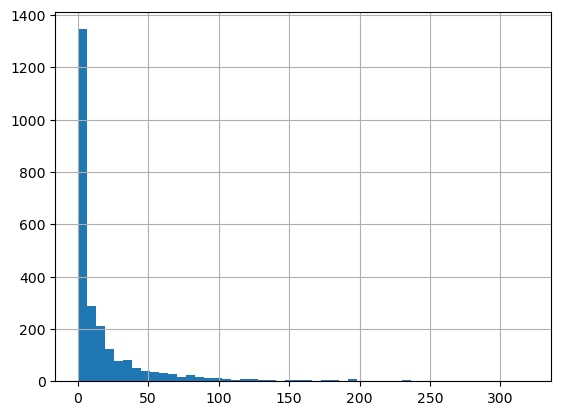

In [89]:
train_inputs['number_of_reviews'].hist(bins=50)

### Create a new ordinal column: convert the number of reviews to ordinal values.

In [90]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['num_reviews_binned'] = pd.cut(df1['number_of_reviews'],
                                       bins=[0,0.5,1,5,15,50,10000],  #bins=[exclusive, inclusive]
                                       labels=False, 
                                       include_lowest=True,
                                       ordered=True)
    
#     You can also do this if you want categorical values:    
#     df1['num_reviews_binned'] = pd.cut(df1['number_of_reviews'],
#                                        bins=[0,0.5,1,5,15,50,10000], 
#                                        labels=['None','Very few','Few','Medium','Many','Too many'], 
#                                        include_lowest=True,
#                                        ordered=False)

    
    return df1[['num_reviews_binned']]
    # You can use this to check whether the calculation is made correctly:
    #return df1
    
   

In [91]:
#Let's test the new function:

# Send train set to the function we created
new_col(train_set)

,num_reviews_binned
1965,4
1450,5
2503,1
944,0
199,2
...,...
1130,5
1294,1
860,4
3507,0


In [92]:
#Check the new distribution

new_col(train_set).value_counts()

num_reviews_binned
0                     517
2                     494
4                     477
3                     456
5                     274
1                     270
Name: count, dtype: int64

##  Identify the numerical and categorical columns

In [93]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [94]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [95]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [96]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [97]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [98]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [99]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [100]:
feat_eng_columns = ['number_of_reviews']

# Pipeline

In [101]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [102]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [103]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [104]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [105]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [106]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.82254842,  0.69215829,  0.54753414, ...,  1.        ,
         1.        ,  0.98257058],
       [ 0.55146572,  0.15729058,  0.54753414, ...,  0.        ,
         1.        ,  1.58648254],
       [ 0.07311286, -1.97951247, -0.59100739, ...,  0.        ,
         0.        , -0.82916529],
       ...,
       [-0.61093878, -0.07631528,  3.96315871, ...,  0.        ,
         1.        ,  0.98257058],
       [ 1.17819153, -0.94575177, -1.16027815, ...,  0.        ,
         0.        , -1.43307725],
       [-0.33618088,  1.03587419, -0.59100739, ...,  0.        ,
         1.        , -1.43307725]])

In [107]:
train_x.shape

(2488, 67)

# Tranform: transform() for TEST

In [108]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[-1.21269719, -1.20324989,  0.54753414, ...,  0.        ,
         1.        , -0.22525333],
       [-2.86419979, -2.67831359, -0.59100739, ...,  0.        ,
         0.        , -1.43307725],
       [-0.11443035,  1.26295963, -0.59100739, ...,  0.        ,
         1.        ,  0.37865862],
       ...,
       [ 0.47803436, -1.63486781, -0.59100739, ...,  1.        ,
         1.        ,  0.98257058],
       [ 0.59928397,  0.34795157,  2.82461719, ...,  0.        ,
         0.        ,  0.37865862],
       [ 0.19953968,  0.22845713, -0.59100739, ...,  0.        ,
         1.        , -1.43307725]])

In [109]:
test_x.shape

(1067, 67)

# Baseline

In [110]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

In [111]:
from sklearn.metrics import accuracy_score

In [112]:
#Baseline Train Accuracy
dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_y, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.3311897106109325


In [113]:
#Baseline Test Accuracy
dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_y, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.3402061855670103


# Multiclass classification



## Hard voting

In [114]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import SGDClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


dtree_clf = DecisionTreeClassifier(max_depth=20)
log_clf = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', C=10, max_iter=1000)
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3)

voting_clf = VotingClassifier(
            estimators=[('dt', dtree_clf), 
                        ('lr', log_clf), 
                        ('sgd', sgd_clf)],
            voting='hard')

voting_clf.fit(train_x, train_y)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=20)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 multi_class='multinomial')),
                             ('sgd', SGDClassifier(max_iter=10000))])

## Accuracy

In [115]:
from sklearn.metrics import accuracy_score

In [116]:
#Train accuracy

train_y_pred = voting_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.742363344051447


In [117]:
#Test accuracy

test_y_pred = voting_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.619493908153702


## Classification Matrix

In [118]:
from sklearn.metrics import confusion_matrix

In [119]:
confusion_matrix(test_y, test_y_pred)

array([[118,  50,  75,   2],
       [ 61, 189,  18,  95],
       [ 33,  17, 171,   0],
       [  4,  50,   1, 183]])

## Inspect each classifier's accuracy

In [120]:
for clf in (dtree_clf, log_clf, sgd_clf, voting_clf):
    clf.fit(train_x, train_y.ravel())
    test_y_pred = clf.predict(test_x)
    print(clf.__class__.__name__, 'Test acc=', accuracy_score(test_y, test_y_pred))

DecisionTreeClassifier Test acc= 0.5791940018744143
LogisticRegression Test acc= 0.6354264292408622
SGDClassifier Test acc= 0.5388940955951266
VotingClassifier Test acc= 0.6344892221180881


## Hard voting with weights

In [121]:
dtree_clf = DecisionTreeClassifier(max_depth=20)
log_clf = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', C=10, max_iter=1000)
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3)

voting_clf = VotingClassifier(
            estimators=[('dt', dtree_clf), 
                        ('lr', log_clf), 
                        ('sgd', sgd_clf)],
            voting='hard',
            weights=[0.6, 0.2, 0.2])

voting_clf.fit(train_x, train_y)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=20)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 multi_class='multinomial')),
                             ('sgd', SGDClassifier(max_iter=10000))],
                 weights=[0.6, 0.2, 0.2])

In [122]:
#Train accuracy

train_y_pred = voting_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.9955787781350482


In [123]:
#Test accuracy

test_y_pred = voting_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.5641986879100281


## Soft voting

In [124]:
#Each model should have predict_proba() function. Otherwise, you can't use it for soft voting
#We can't use sgd, because it doesn't have predict_proba() function.

voting_clf = VotingClassifier(
            estimators=[('dt', dtree_clf), 
                        ('lr', log_clf)],
            voting='soft')

voting_clf.fit(train_x, train_y)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=20)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 multi_class='multinomial'))],
                 voting='soft')

In [125]:
#Train accuracy

train_y_pred = voting_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.9951768488745981


In [126]:
#Test accuracy

test_y_pred = voting_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.5679475164011246


# Bagging

In [127]:
from sklearn.ensemble import BaggingClassifier 


#If you want to do pasting, change "bootstrap=False"
#n_jobs=-1 means use all CPU cores
#bagging automatically performs soft voting

bag_clf = BaggingClassifier( 
            SGDClassifier(), n_estimators=50, 
            max_samples=1000, bootstrap=True, n_jobs=-1) 

bag_clf.fit(train_x, train_y)



BaggingClassifier(estimator=SGDClassifier(), max_samples=1000, n_estimators=50,
                  n_jobs=-1)

In [128]:
#Train accuracy

train_y_pred = bag_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.6121382636655949


In [129]:
#Test accuracy

test_y_pred = bag_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.6035613870665417


## Random Patches

In [130]:
#Random Patches: see the max_features variable
bag_clf = BaggingClassifier( 
            SGDClassifier(), n_estimators=50, max_features=10,
            max_samples=1000, bootstrap=True, n_jobs=-1) 

bag_clf.fit(train_x, train_y)

BaggingClassifier(estimator=SGDClassifier(), max_features=10, max_samples=1000,
                  n_estimators=50, n_jobs=-1)

In [131]:
#Train accuracy

train_y_pred = bag_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.5418006430868167


In [132]:
#Test accuracy

test_y_pred = bag_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.5745079662605436


## Random Subspaces

In [133]:
#Random subspaces: see the max_samples variable
bag_clf = BaggingClassifier( 
            SGDClassifier(), n_estimators=50, max_features=10,
            max_samples=len(train_x), bootstrap=True, n_jobs=-1) 

bag_clf.fit(train_x, train_y)

BaggingClassifier(estimator=SGDClassifier(), max_features=10, max_samples=2488,
                  n_estimators=50, n_jobs=-1)

In [134]:
#Train accuracy

train_y_pred = bag_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.5385852090032154


In [135]:
#Test accuracy

test_y_pred = bag_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.5548266166822868


# Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier 

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1) 

rnd_clf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [137]:
#Train accuracy

train_y_pred = rnd_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 1.0


In [138]:
#Test accuracy

test_y_pred = rnd_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.6916588566073102


### Feature Importance

In [139]:
rnd_clf.feature_importances_

array([1.00992478e-01, 9.55764792e-02, 5.59390822e-02, 2.34916973e-02,
       4.24996864e-02, 2.75366519e-02, 6.85339066e-02, 2.23567607e-02,
       3.10936956e-02, 3.92095449e-02, 5.01848118e-02, 5.19514110e-02,
       4.80468137e-02, 6.19150396e-03, 9.28507024e-03, 9.83736800e-04,
       5.90369041e-03, 5.69470273e-03, 4.00011211e-03, 2.69498374e-03,
       9.14334604e-03, 7.40967964e-03, 5.08653163e-03, 6.74381858e-03,
       7.56755732e-04, 5.17426583e-03, 3.62903060e-05, 4.10472419e-04,
       1.00227584e-03, 3.21527560e-03, 4.30027548e-03, 1.50766167e-03,
       3.58413953e-03, 4.47044504e-03, 3.61241966e-03, 8.19526218e-03,
       2.04264163e-03, 1.27539450e-03, 1.05860225e-02, 2.21748608e-03,
       4.50017272e-04, 1.59548940e-04, 5.96858673e-03, 1.51345291e-04,
       1.45585487e-04, 1.82853339e-05, 8.66894905e-03, 1.78427691e-03,
       1.02198612e-03, 2.80303549e-03, 3.15091233e-04, 1.47397072e-04,
       5.16893340e-02, 4.03911416e-02, 3.55251821e-03, 9.12442938e-04,
      

In [140]:
# Round to two decimals
np.round(rnd_clf.feature_importances_,2)

array([0.1 , 0.1 , 0.06, 0.02, 0.04, 0.03, 0.07, 0.02, 0.03, 0.04, 0.05,
       0.05, 0.05, 0.01, 0.01, 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.01,
       0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.04, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.03])

# Extra-Trees

In [141]:
from sklearn.ensemble import ExtraTreesClassifier 

ext_clf = ExtraTreesClassifier(n_estimators=500,  n_jobs=-1) 

ext_clf.fit(train_x, train_y)

ExtraTreesClassifier(n_estimators=500, n_jobs=-1)

In [142]:
#Train accuracy

train_y_pred = ext_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 1.0


In [143]:
#Test accuracy

test_y_pred = ext_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.6738519212746017


# AdaBoost

In [144]:
from sklearn.ensemble import AdaBoostClassifier 

#Create Adapative Boosting with Decision Stumps (depth=1)
ada_clf = AdaBoostClassifier( 
            DecisionTreeClassifier(max_depth=1), n_estimators=500, 
            learning_rate=0.1) 


ada_clf.fit(train_x, train_y)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=500)

In [145]:
#Train accuracy

train_y_pred = ada_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.5743569131832797


In [146]:
#Test accuracy

test_y_pred = ada_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.5735707591377694


# Gradient Boosting

In [147]:
#Use GradientBoosting

from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(max_depth=2, n_estimators=100, learning_rate=0.1) 

gbclf.fit(train_x, train_y)

GradientBoostingClassifier(max_depth=2)

In [148]:
#Train accuracy

train_y_pred = gbclf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.6792604501607717


In [149]:
#Test accuracy

test_y_pred = gbclf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.6504217432052484


# Stochastic Gradient Boosting

In [150]:
#Train on 75% of the sample only

gbclf = GradientBoostingClassifier(max_depth=2, n_estimators=100, 
                                   learning_rate=0.1, subsample=0.75) 

gbclf.fit(train_x, train_y)

GradientBoostingClassifier(max_depth=2, subsample=0.75)

In [151]:
#Train accuracy

train_y_pred = gbclf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.6877009646302251


In [152]:
#Test accuracy

test_y_pred = gbclf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.6438612933458294


# Selecting the number of estimators

In [153]:
for x in range(1,30):
    gbclf = GradientBoostingClassifier(max_depth=3, n_estimators=x, learning_rate=1.0) 
    gbclf.fit(train_x, train_y.ravel())
    
    train_predictions = gbclf.predict(train_x)
    test_predictions = gbclf.predict(test_x)
    
    train_accuracy = round(accuracy_score(train_y, train_predictions),4)
    test_accuracy = round(accuracy_score(test_y, test_predictions),4)
    
    print('# Estimators = {}'.format(x) + "     " + 'Train accuracy = {}'.format(train_accuracy) + "   "
         'Test accuracy = {}'.format(test_accuracy))

# Estimators = 1     Train accuracy = 0.5824   Test accuracy = 0.5445
# Estimators = 2     Train accuracy = 0.5949   Test accuracy = 0.5764
# Estimators = 3     Train accuracy = 0.6258   Test accuracy = 0.5989
# Estimators = 4     Train accuracy = 0.6499   Test accuracy = 0.5979
# Estimators = 5     Train accuracy = 0.662   Test accuracy = 0.5895
# Estimators = 6     Train accuracy = 0.6845   Test accuracy = 0.5904
# Estimators = 7     Train accuracy = 0.7066   Test accuracy = 0.5989
# Estimators = 8     Train accuracy = 0.7154   Test accuracy = 0.597
# Estimators = 9     Train accuracy = 0.7259   Test accuracy = 0.5895
# Estimators = 10     Train accuracy = 0.7367   Test accuracy = 0.5904
# Estimators = 11     Train accuracy = 0.7472   Test accuracy = 0.5876
# Estimators = 12     Train accuracy = 0.7588   Test accuracy = 0.5886
# Estimators = 13     Train accuracy = 0.7721   Test accuracy = 0.5876
# Estimators = 14     Train accuracy = 0.7741   Test accuracy = 0.5951
# Estimators = 15

# Early Stopping

In [154]:
#Notice that learning rate and tol are high to see early stopping
gbclf = GradientBoostingClassifier(max_depth=2, n_estimators=100, 
                                   learning_rate=1, 
                                  tol=0.1, n_iter_no_change=5, validation_fraction=0.2,
                                  verbose=1) 

gbclf.fit(train_x, train_y.ravel())

      Iter       Train Loss   Remaining Time 
         1           1.0518            0.83s
         2           0.9628            0.82s
         3           0.9204            0.80s
         4           0.8903            0.79s
         5           0.8599            0.77s
         6           0.8420            0.76s
         7           0.8204            0.75s


GradientBoostingClassifier(learning_rate=1, max_depth=2, n_iter_no_change=5,
                           tol=0.1, validation_fraction=0.2, verbose=1)

In [155]:
gbclf.n_estimators_

7

In [156]:
#Train accuracy

train_y_pred = gbclf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.6334405144694534


In [157]:
#Test accuracy

test_y_pred = gbclf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.6213683223992502


# Extreme Gradient Boosting (XGBoost)

First, start Anaconda Command Prompt, and type `pip install xgboost` to install XGBoost. Otherwise, default Anaconda installation doesn't include XGBoost. 

In [158]:
import xgboost

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xgb_clf = xgboost.XGBClassifier()

xgb_clf.fit(train_x, train_y)

In [ ]:
#Train accuracy

train_y_pred = xgb_clf.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

In [ ]:
#Test accuracy

test_y_pred = xgb_clf.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))